# Forecasting stratigies

This notebook describes some strategies of foreacsting.

Notebook navigation:

- [Pipeline](#21-pipeline)
- [AutoregressivePipeline](#22-autoregressivepipeline)
- [DirectEnsemble](#23-directensemble)
- [assemble_pipelines + DirectEnsemble](#24-assemble-pipelines-with-directensemble)

In [1]:
import warnings

warnings.filterwarnings("ignore")

## 1. Load Dataset

In this notebook we will work with the dataset contains only one segment with monthly wine sales. Working process with the dataset containing more segments will be absolutely the same.

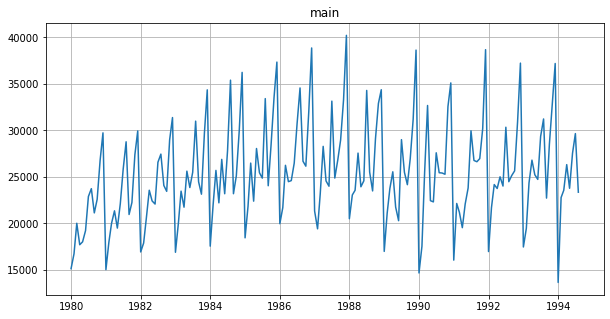

In [2]:
import pandas as pd
from etna.datasets import TSDataset

original_df = pd.read_csv("data/monthly-australian-wine-sales.csv")
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df=df, freq="MS")
ts.plot()

In [3]:
HORIZON = 14

## 2. Strategies

### 2.1 Pipeline

Pipeline is a base strategy of forecasting. It accepts as input model, list of transforms and horizon. In fit method pipeline transforms data with input transforms and after that it gives data to model, which give us one vector - our forecastings. Let's see an expample of usage:

In [4]:
from etna.pipeline import Pipeline
from etna.models import CatBoostModelPerSegment
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import TrendTransform
from etna.metrics import SMAPE

model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=list(range(HORIZON + 1, 40)), out_column="target_lag"),
    DateFlagsTransform(week_number_in_month=True, out_column="date_flag"),
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.8s finished


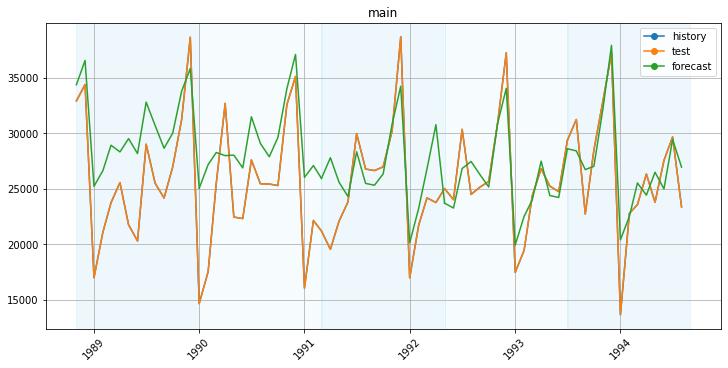

In [5]:
from etna.analysis import plot_backtest

plot_backtest(forecast_df, ts)

In [6]:
metrics_df

,segment,SMAPE,fold_number
0,main,17.078965,0
0,main,20.759650,1
0,main,11.687629,2
0,main,6.073650,3
0,main,9.250056,4


## 2.2 AutoregressivePipeline

AutoRegressive pipeline is pipeline, which iteratively horizon times forecasts one value and use forecasted value as feature in a next steps. Let's look an example of usage: 

In [7]:
from etna.pipeline import AutoRegressivePipeline
from etna.models import CatBoostModelPerSegment
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import TrendTransform
from sklearn.tree import DecisionTreeRegressor
from etna.transforms import DateFlagsTransform, LinearTrendTransform, TreeFeatureSelectionTransform
from etna.transforms import DateFlagsTransform, HolidayTransform


model = CatBoostModelPerSegment()
transforms = [
    LagTransform(in_column="target", lags=[HORIZON + i for i in range(1, 20)], out_column="target_lag"),
    TreeFeatureSelectionTransform(model=DecisionTreeRegressor(), top_k=10),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        special_days_in_week=[4],
        out_column="date_flag",
    ),
]

pipeline = AutoRegressivePipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.1s finished


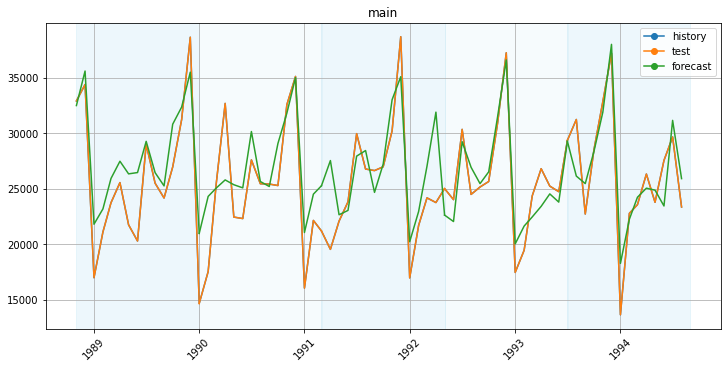

In [8]:
plot_backtest(forecast_df, ts)

In [9]:
metrics_df

,segment,SMAPE,fold_number
0,main,9.624637,0
0,main,12.922913,1
0,main,11.501239,2
0,main,6.605075,3
0,main,7.851975,4


## 2.3 DirectEnsemble

DirectEnsemble is a pipeline that forecasts future values merging the forecasts of base pipelines. For each future value we choose base pipeline with shortest horizon, which covers timestamp of interesitng value. Let's see an example of choosing base-pipeline for forecastings:

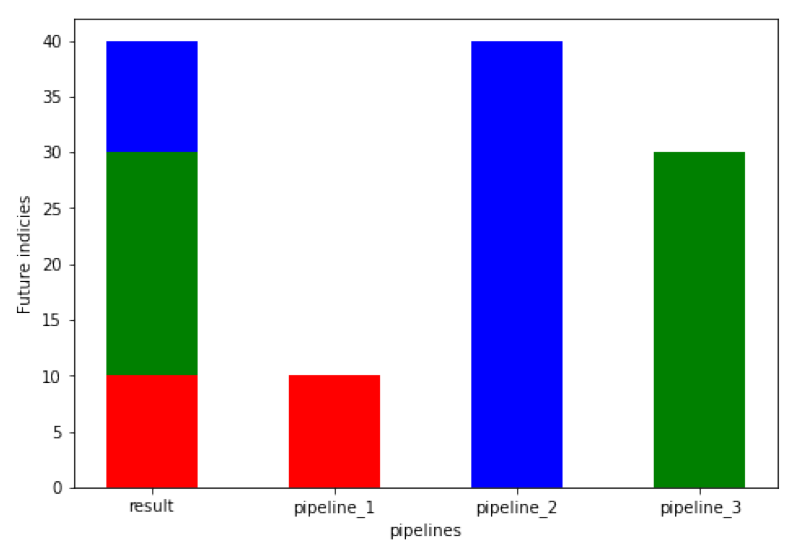

In [10]:
import matplotlib.pyplot as plt

img = plt.imread("./assets/forecasting_strategies/ensemle.png")
plt.figure(figsize=(15, 10))
plt.axis("off")
_ = plt.imshow(img)

Let's build DirectEnsemble with etna:

First, let's build our pipelines:

In [11]:
train_ts, test_ts = ts.train_test_split(test_size=14)

In [12]:
from etna.models import NaiveModel

horizons = [14, 5]

model_1 = CatBoostModelPerSegment()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=list(range(horizons[0], 122)), out_column="target_lag"),
    DateFlagsTransform(week_number_in_month=True, out_column="date_flag"),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = NaiveModel(lag=1)
transforms_2 = []

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

Secondly, we will create ensemble and forecasts:

In [14]:
from etna.ensembles import DirectEnsemble

ensemble = DirectEnsemble(pipelines=[pipeline, pipeline_2])

metrics_df, forecast_df, fold_info_df = ensemble.backtest(ts=ts, metrics=[SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

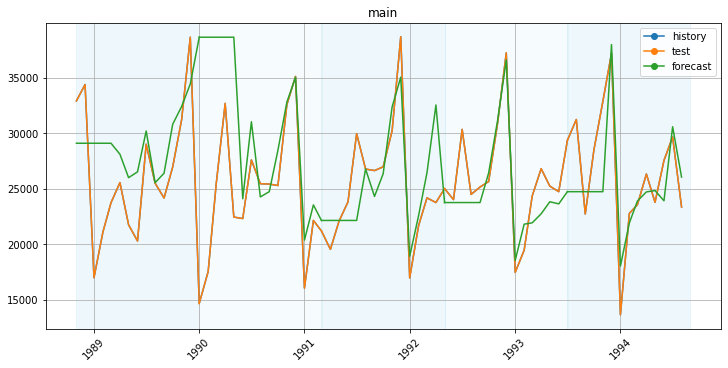

In [15]:
plot_backtest(forecast_df, ts)

In [16]:
metrics_df

,segment,SMAPE,fold_number
0,main,16.357601,0
0,main,24.668510,1
0,main,9.837015,2
0,main,7.097556,3
0,main,11.776255,4


As we can see, the first values of forecasts are constant (it is NaiveModel) and after that it became non-constant (Catboost model).

## 2.4 assemble pipelines with DirectEnsemble

DirectEnsemble was described above, so let's look at assemble pipelines. `assemble_pipelines` is a function, that generate `Pipelines` from a set of input models, transforms and horizons by some rules:

1. Input models could be given to function as one model or as a sequence of models. In first case all generated pipelines will have input model and in the second case `i`-th pipeline will hold `i`-th model. 
2. Analogically paragraph 1, but for horizons.
3. Transforms could be given as a sequence of transform or as a sequence of sequence of transforms. Let's look at some examples to understand better transforms:

Let's consider that `A`, `B`, `C`, `D`, `E` are different transforms.

### Example 1

If input transform sequence is `[A, B, C]`, function will transformate in `[A, B, C]` for each pipeline

### Example 2

If input transform sequence is `[A, [B, C], D, E]`, function will put `[A, B, D, E]` for the first generated pipeline and `[A, C, D, E]` for the second.

### Example 3

If input transform sequence is `[A, [B, C], [D, E]]`, function will put `[A, B, D]` for the first generated pipeline and `[A, C, E]` for the second.

### Example 4

If input transform sequence is `[A, [B, None]]`, function will put `[A, B]` for the first generated pipeline and `[A]` for the second.



Now let's try to generate pipelines and give it to DirectEnsemble:



In [17]:
from etna.pipeline import assemble_pipelines
from etna.models import LinearPerSegmentModel
from etna.transforms import DateFlagsTransform, HolidayTransform


models = [CatBoostModelPerSegment(), LinearPerSegmentModel()]
transforms = [
    LagTransform(in_column="target", lags=list(range(20, 25)), out_column="target_lag"),
    [DateFlagsTransform(day_number_in_month=True, out_column="date_flag"), None],
]
horizons = [15, 8]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LagTransform(in_column = 'target', lags = [20, 21, 22, 23, 24], out_column = 'target_lag', ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = 'date_flag', )], horizon = 15, ),
 Pipeline(model = LinearPerSegmentModel(fit_intercept = True, ), transforms = [LagTransform(in_column = 'target', lags = [20, 21, 22, 23, 24], out_column = 'target_lag', )], horizon = 8, )]

Now we can simply put our pipelines into DirectEnsemble:

In [18]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_df, forecast_df, fold_info_df = ensemble.backtest(ts=ts, metrics=[SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

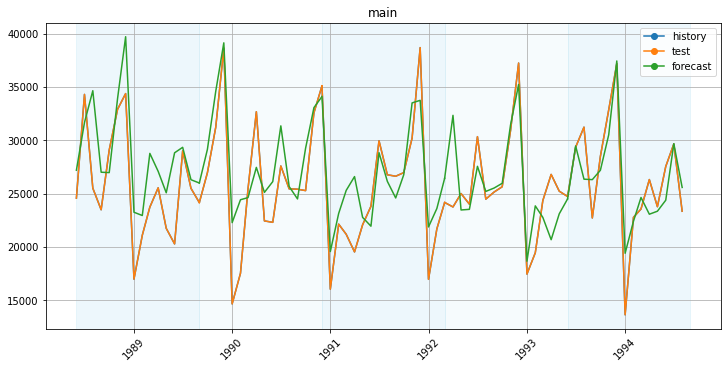

In [19]:
plot_backtest(forecast_df, ts)

In [20]:
metrics_df

,segment,SMAPE,fold_number
0,main,13.678711,0
0,main,12.106576,1
0,main,10.609630,2
0,main,9.239416,3
0,main,8.189450,4
